In [1]:
# –––– Purpose of this script –––– 

# Generate a report on the feedback metrics of your Freshdesk account's public articles

# BEWARE that this script calls the Freshdesk API many times depending on the size of your knowledge base.
# You may want to check that this won't max out your rate limit: https://developers.freshdesk.com/api/#ratelimit

# The script:
# 1. Retrieves the Category IDs from Freshdesk's API
# 2. Retrieves the Folder IDs within each Category
# 3. Retrieves the meta data of each Article within each Folder within each Category
# 4. Exports the full results to a CSV in your working directory
# 5. Represents a selection of the most/least viewed and the highest/lowest rated


In [29]:
# –––– Preperations before this script can run –––– 


# Provide some details:

desk_name = 'your_Freshdesk_account_name'
# This is your Freshdesk URL without '.freshdesk.com' on the end. 
# eg: if your full URL is 'megashop.freshdesk.com' use 'megashop'

auth_deets = ('your_API_key', "your_Freshdesk_password") 
# Your Freshdesk API key is in your Freshdesk profile: https://support.freshdesk.com/support/solutions/articles/215517-how-to-find-your-api-key
# A password must be provided but it does not appear to be verified. I haven't confirmed with Freshdesk if this is a bug. 
# For security's sake, you can leave the password as it is or enter in some humourous nonsense for your own satisfaction. 

no_of_articles = 10
# This is how many articles you would like to presented in each of the four plots
# Eg. leave it at 10 to see '10 most viewed', '10 least viewed', '10 highest rated', and '10 lowest rated'

csv_title = 'all_article_metrics' + '.csv'
# select a different title for the exported CSV, which will land in your working directory





In [ ]:
# –––– From here on you should be able to run the script without any other input –––– 





In [3]:
# –––– Import libraries –––– 

import requests as r
import json
import pandas as pd
import re
from datetime import date, datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np



# –––– Prepare function to report query errors –––– 

def reporter(query):
    if query.status_code != 200:
        print("Query didn't work: ", query.status_code, query.reason, query.url)


# –––– Prepare desk URL for API calls –––– 

desk_URL = 'https://' + desk_name + '.freshdesk.com'





In [4]:
# –––– 1. Retrieve Category IDs –––– 

cat_query = r.get(desk_URL + "/api/v2/solutions/categories", 
                  auth = auth_deets)

reporter(cat_query)

cat_ids = [cat_query.json()[x]['id'] for x in range(len(cat_query.json()))]

In [33]:
# –––– 2. Retrieve Folder IDs –––– 

folder_ids = []
for cat in cat_ids:
    query = r.get(desk_URL + "/api/v2/solutions/categories/" + str(cat) + "/folders", 
                  auth = auth_deets)
    folder_ids.extend([query.json()[x]['id'] for x in range(len(query.json())) if query.json()[x]['visibility'] != 3]) #removes any articles visible only to agents
    print("Folders in Category", cat, query.reason)

print("All Folder IDs retrieved")





Folders in Category 36000065246 OK
Folders in Category 36000113301 OK
Folders in Category 36000121580 OK
Folders in Category 36000061485 OK
Folders in Category 36000061486 OK
Folders in Category 36000061487 OK
Folders in Category 36000061488 OK
Folders in Category 36000061490 OK
Folders in Category 36000020098 OK
All Folder IDs retrieved


In [31]:
# –––– 3. Retrieve Article data –––– 

arts = []
for folder in folder_ids:
    query = r.get(desk_URL + "/api/v2/solutions/folders/" + str(folder) + "/articles", 
                  auth = auth_deets)
    print("Articles in Folder", folder, query.reason)
    arts.extend([query.json()[x] for x in range(len(query.json()))])
    
print("All Articles retrieved")





Folder 36000174917 OK
Folder 36000174919 OK
Folder 36000174920 OK
Folder 36000174922 OK
Folder 36000174921 OK
Folder 36000181545 OK
Folder 36000190205 OK
Folder 36000093670 OK
Folder 36000093671 OK
Folder 36000093673 OK
Folder 36000093676 OK
Folder 36000093675 OK
Folder 36000093677 OK
Folder 36000172414 OK
Folder 36000093674 OK
Folder 36000093672 OK
Folder 36000169338 OK
Folder 36000093678 OK
Folder 36000093679 OK
Folder 36000093683 OK
Folder 36000129289 OK
Folder 36000093684 OK
Folder 36000093685 OK
Folder 36000131060 OK
Folder 36000097513 OK
Folder 36000097517 OK
Folder 36000099230 OK
Folder 36000099231 OK
Folder 36000099232 OK
Folder 36000169817 OK
Folder 36000099233 OK
Folder 36000097521 OK
Folder 36000097522 OK
Folder 36000097523 OK
Folder 36000097524 OK
Folder 36000131895 OK
Folder 36000136116 OK
Folder 36000134053 OK
Folder 36000134060 OK
Folder 36000093669 OK
Folder 36000030404 OK
Folder 36000030405 OK
All Articles retrieved


In [12]:
# Convert to dataframe and calculate positive ratings

columns = list(arts[1].keys())
df = pd.DataFrame(arts, columns = columns)
df['positive_rating'] = round(df['thumbs_up'] / (df['thumbs_down'] + df['thumbs_up']) *100, 1)
df['total_ratings'] = df['thumbs_down'] + df['thumbs_up']





In [13]:
# –––– 4. Export the full results to CSV –––– 

df[['title', 'positive_rating', 'total_ratings', 'hits']].sort_values(by = 'positive_rating', 
                                                                      ascending = True, 
                                                                      axis = 0).set_index('title', 
                                                                                          inplace = False).to_csv(csv_title)


In [14]:
# –––– 5. Generate plot for top/bottom selection –––– 


# Create a color scale for 0-100 in 0.1 intervals
# There must be a cleaner way to do this. I want all plots to work on the same colour scale.
# Using a normal pallete applies the max and min to the max and min of each individual plot, not the full range (0 to 100).
# This scale does the trick but slows down plotting and feels cumbersome.

import numpy as np

gradient = sns.color_palette("RdYlBu", 1001)
percents = np.arange(0, len(gradient), 0.1)
percent_colours = {}

for x, y in zip(gradient, percents):
    percent_colours.setdefault(round(y, 1), x)

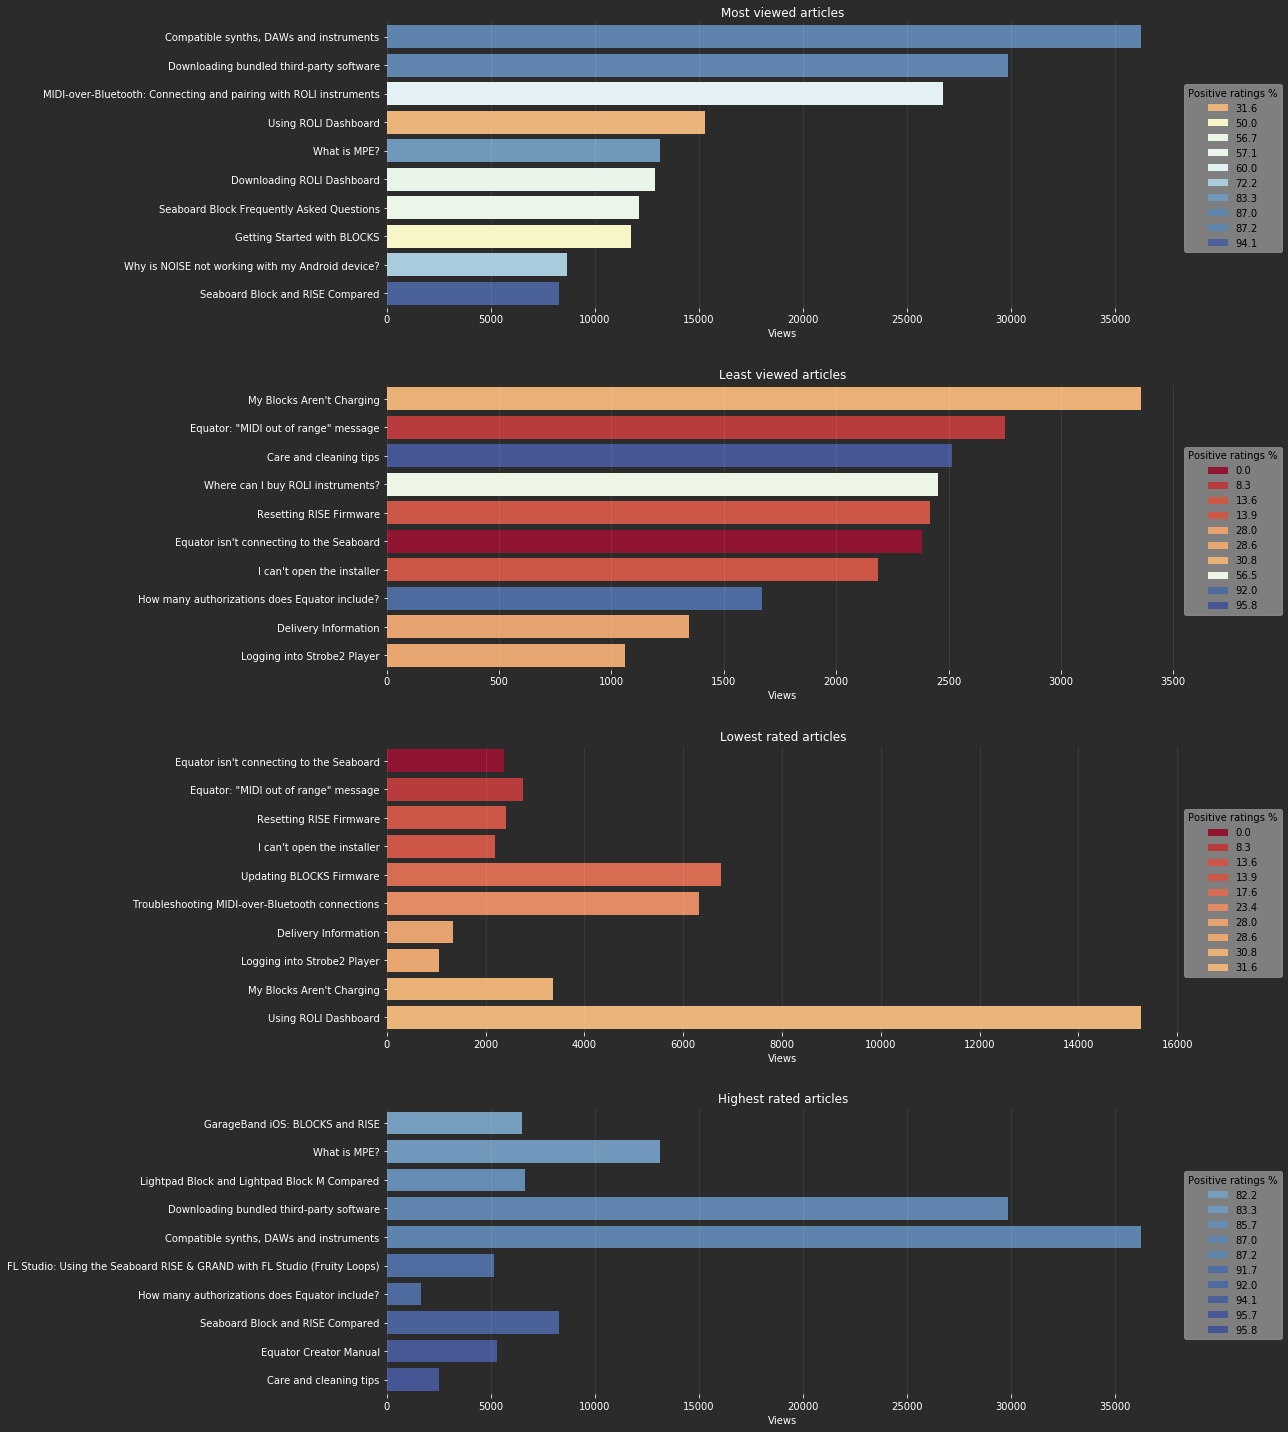

In [44]:
fig = plt.figure(facecolor = '#2b2b2b', figsize=(18, no_of_articles * 2))



plt.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(4, 1, 1, frame_on = False)
ax3 = fig.add_subplot(4, 1, 2, frame_on = False)
ax2 = fig.add_subplot(4, 1, 3, frame_on = False)
ax4 = fig.add_subplot(4, 1, 4, frame_on = False)


#ax1 top viewed articles coloured by rating
subdf = df[['title', 'positive_rating', 'total_ratings', 'hits']][df['total_ratings'] > 20].sort_values(by='hits', ascending = False, axis = 0).head(no_of_articles)



sns.barplot(x = 'hits', 
                 y = 'title', 
                 hue = 'positive_rating',
                 data = subdf,
                 palette = percent_colours,
                 dodge = False,
                 ax = ax1
                 ) 
ax1.set_title('Most viewed articles')



#ax3 bottom viewed articles coloured by rating
subdf = df[['title', 'positive_rating', 'total_ratings', 'hits']][df['total_ratings'] > 20].sort_values(by='hits', ascending = False, axis = 0).tail(no_of_articles)
sns.barplot(x = 'hits', 
                 y = 'title', 
                 hue = 'positive_rating',
                 data = subdf,
                 palette = percent_colours,
                 dodge = False,
                 ax = ax3
                 ) 
ax3.set_title('Least viewed articles')



#ax2 bottom rated articles
subdf = df[['title', 'positive_rating', 'total_ratings', 'hits']][df['total_ratings'] > 20].sort_values(by='positive_rating', ascending = True, axis = 0).head(no_of_articles)
sns.barplot(x = 'hits', 
                 y = 'title', 
                 hue = 'positive_rating',
                 data = subdf,
                 palette = percent_colours,
                 dodge = False,
                 ax = ax2
                 )
ax2.set_title('Lowest rated articles')


#ax4 top rated articles
subdf = df[['title', 'positive_rating', 'total_ratings', 'hits']][df['total_ratings'] > 20].sort_values(by='positive_rating', ascending = True, axis = 0).tail(no_of_articles)
sns.barplot(x = 'hits', 
                 y = 'title', 
                 hue = 'positive_rating',
                 data = subdf,
                 palette = percent_colours,
                 dodge = False,
                 ax = ax4
                 )
ax4.set_title('Highest rated articles')




all_axes = [ax1, ax2, ax3, ax4]

for ax in all_axes:
    ax.grid(axis = 'x', color = '1', linestyle = '-', linewidth = 1, alpha = 0.08)
    ax.tick_params(axis = 'x', colors = 'white')
    ax.tick_params(axis = 'y', colors = 'white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.set_facecolor('#2b2b2b')
    ax.legend(title = 'Positive ratings %', framealpha = 0.4,  bbox_to_anchor = (1, 0.8), loc = 2)
    ax.set(ylabel = None, xlabel = 'Views')
    
    
plt.tight_layout(h_pad = 3)

plt.savefig('article_metrics_report.png', dpi = 100, frameon = True, pad_inches = 1, facecolor = '#2b2b2b')